# Learning the identity with neural networks

We try to reproduce the problem of learning neural networks that learn the identity function and extrapolate beyond the training range. See 1.1 (and Figure 1) in Trask et al. https://arxiv.org/pdf/1808.00508.pdf

In [1]:
import torch
from torch import Tensor, nn, optim
import torch.nn.functional as F

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Training and extrapolation work perfectly if we do not add any non-linearity. But adding any activation function makes extrapolation fail at some points. The first model uses RELU which is very close to linear.

### Initialize model and optimizer

In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 20)
        self.h2 = nn.Linear(20, 1)

    def forward(self, xb):
        return self.h2(F.relu(self.h1(xb)))

In [3]:
mod = MyModel()
opt = optim.SGD(mod.parameters(), lr=.05)

In [4]:
mod(Tensor([7]))

tensor([-2.3778], grad_fn=<AddBackward0>)

### Use MSE as loss function

In [5]:
loss_func = F.mse_loss

In [6]:
loss_func(Tensor([7]), Tensor([6]))

tensor(1.)

In [7]:
loss_func(mod(Tensor([7])), Tensor([7]))

tensor(87.9441, grad_fn=<MseLossBackward>)

### Generate random training data (in the range [0,1])

In [8]:
x = torch.rand(1000)

### Train network for 10 epochs

In [9]:
for epoch in tqdm(range(10)):
    for i in x:
        pred = mod(i.unsqueeze(0))
        loss = loss_func(pred, i.unsqueeze(0))

        loss.backward()
        opt.step()
        opt.zero_grad()

  0%|          | 0/10 [00:00<?, ?it/s]

### Results of trained network

In [10]:
mod(Tensor([5]))

tensor([3.3536], grad_fn=<AddBackward0>)

In [11]:
points = [[x,mod(Tensor([x])).item()] for x in np.linspace(-10,100,1000)]

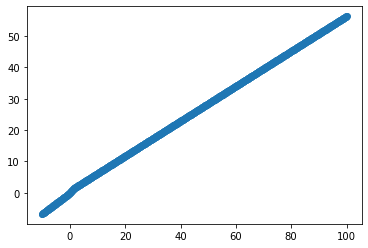

In [12]:
plt.scatter([x[0] for x in points], [x[1] for x in points])

### Initialize second model and optimizer (closer to the paper)

In [13]:
class MyModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 8)
        self.h2 = nn.Linear(8, 8)
        self.h3 = nn.Linear(8, 8)
        self.h4 = nn.Linear(8, 1)

    def forward(self, xb):
        res = torch.tanh(self.h1(xb))
        res = torch.tanh(self.h2(res))
        res = torch.tanh(self.h3(res))
        res = self.h4(res)
        return res

In [14]:
mod2 = MyModel2()
opt2 = optim.SGD(mod2.parameters(), lr=.01)

In [15]:
for epoch in tqdm(range(10)):
    for i in x:
        pred = mod2(i.unsqueeze(0))
        loss = loss_func(pred, i.unsqueeze(0))

        loss.backward()
        opt2.step()
        opt2.zero_grad()

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
mod2(Tensor([.3]))

tensor([0.2987], grad_fn=<AddBackward0>)

In [17]:
mod2(Tensor([-1]))

tensor([-0.4931], grad_fn=<AddBackward0>)

In [18]:
points = [[x,mod2(Tensor([x])).item()] for x in np.linspace(-2,2,1000)]

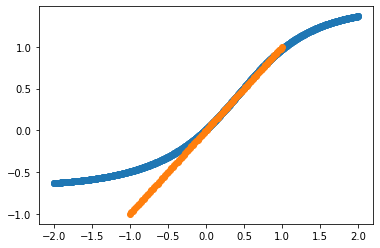

In [19]:
plt.scatter([x[0] for x in points], [x[1] for x in points])
plt.scatter(np.linspace(-1,1,100),np.linspace(-1,1,100))